# Converting image to numpy format

In [17]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 1. OPEN THE V7.3 MAT FILE WITH H5PY
mat_filepath = "data/assignmentSegmentBrain.mat"
with h5py.File(mat_filepath, 'r') as f:
    # Inspect the keys to see what's stored
    print("Keys in the MAT file:", list(f.keys()))
    
    # Typically, if your MATLAB variables are named 'imageData' and 'imageMask'
    # you should see them listed here. We can then read them like this:
    imageData = np.array(f['imageData'])   # might need transpose
    imageMask = np.array(f['imageMask'])   # might need transpose

# 2. CHECK SHAPES AND ORIENTATIONS
print("Loaded imageData shape:", imageData.shape)
print("Loaded imageMask shape:", imageMask.shape)

imageData = imageData.T
imageMask = imageMask.T

print("Transposed imageData shape:", imageData.shape)
print("Transposed imageMask shape:", imageMask.shape)

# 3. CONVERT TYPES (IF DESIRED) AND CHECK RANGE
imageData = imageData.astype(np.float32)
imageMask = imageMask.astype(np.uint8)

print("imageData range:", (imageData.min(), imageData.max()))
print("imageMask unique values:", np.unique(imageMask))

# 4. SAVE AS NUMPY ARRAYS, IF YOU LIKE
os.makedirs("data", exist_ok=True)
np.save("data/imageData.npy", imageData)
np.save("data/imageMask.npy", imageMask)
print("Saved to data/imageData.npy and data/imageMask.npy")

# 5. EXTRACT BRAIN VOXELS FOR HISTOGRAM (MASK == 1)
brain_voxels = imageData[imageMask == 1]


Keys in the MAT file: ['imageData', 'imageMask']
Loaded imageData shape: (256, 256)
Loaded imageMask shape: (256, 256)
Transposed imageData shape: (256, 256)
Transposed imageMask shape: (256, 256)
imageData range: (0.0002205498, 1.3859525)
imageMask unique values: [0 1]
Saved to data/imageData.npy and data/imageMask.npy


## Image Visualization

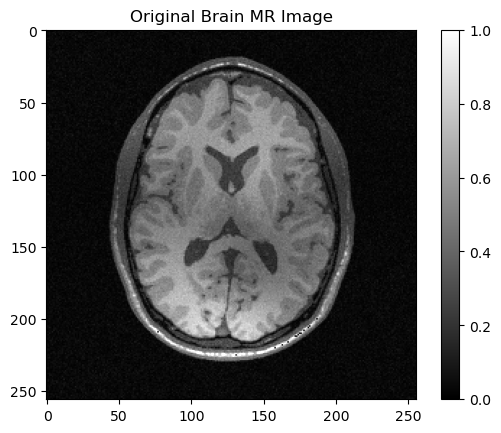

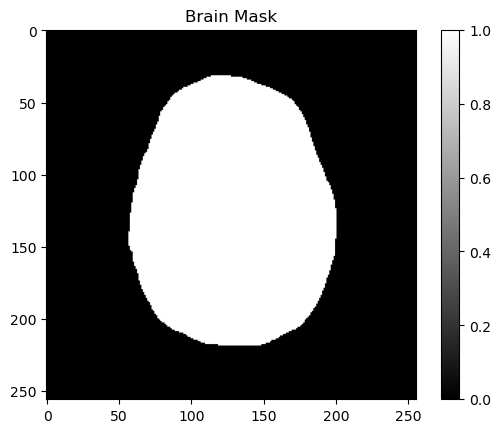

In [18]:
# ------------------------------------------------------------------------------
# 5. VISUALIZE & SAVE THE ORIGINAL IMAGE AND MASK
# ------------------------------------------------------------------------------
os.makedirs("images", exist_ok=True)

# -- Show and save the original image
plt.figure()
plt.imshow(imageData, cmap='gray', vmin=0, vmax=1)
plt.title("Original Brain MR Image")
plt.colorbar()
plt.savefig("images/original_image.png", dpi=150)
plt.show()

# -- Show and save the mask
plt.figure()
plt.imshow(imageMask, cmap='gray')
plt.title("Brain Mask")
plt.colorbar()
plt.savefig("images/brain_mask.png", dpi=150)
plt.show()

## Historgram approach for mean initialization

In [ ]:

# 6. HISTOGRAM + PEAK DETECTION
hist, bin_edges = np.histogram(brain_voxels, bins=45, range=(0, 1))
peaks, _ = find_peaks(hist, prominence=1)

if len(peaks) < 3:
    print(f"Only found {len(peaks)} peaks. Using them all or consider fallback.")
top_n = min(3, len(peaks))

peak_heights = hist[peaks]
sorted_idx = np.argsort(peak_heights)[::-1]
top_peaks = peaks[sorted_idx[:top_n]]
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

top_intensities = bin_centers[top_peaks]
initial_class_means = np.sort(top_intensities)
print("Initial class means from histogram:", initial_class_means)

# 7. OPTIONAL: VISUALIZE
plt.figure()
plt.plot(bin_centers, hist, label='Histogram')
plt.plot(bin_centers[top_peaks], hist[top_peaks], "x", label='Peaks')
for i, val in enumerate(top_intensities):
    plt.axvline(val, linestyle='--', alpha=0.7, label=f"Peak {i+1}: {val:.3f}")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.title("Histogram of Brain Voxels + Detected Peaks")
plt.legend()
plt.show()


## Kmeans approach for mean initialization

In [11]:
from sklearn.cluster import KMeans
# ------------------------------------------------------------------------------
# 4. QUICK K-MEANS TO VALIDATE
# ------------------------------------------------------------------------------
# Run a very quick k-means on the masked voxels to find 3 cluster centers
brain_voxels_2d = brain_voxels.reshape(-1, 1)  # shape (N,1)

kmeans = KMeans(n_clusters=3, random_state=25, n_init=10)
kmeans.fit(brain_voxels_2d)

c_kmeans = np.sort(kmeans.cluster_centers_.flatten())

print("K-Means initial means          =", c_kmeans)


K-Means initial means          = [0.22448622 0.45322847 0.6341621 ]


## Initial guess of means is average of K-Means and Histogram peaks:
### (As the mean values are pretty close here in both approaches)

In [15]:
initial_means =  (c_kmeans + initial_class_means)/2

print(f"Final initial means: {initial_means}")

Final initial means: [0.22890978 0.46550313 0.61152554]


## Initialisation of membership map

Saved membership_init\membership.npy


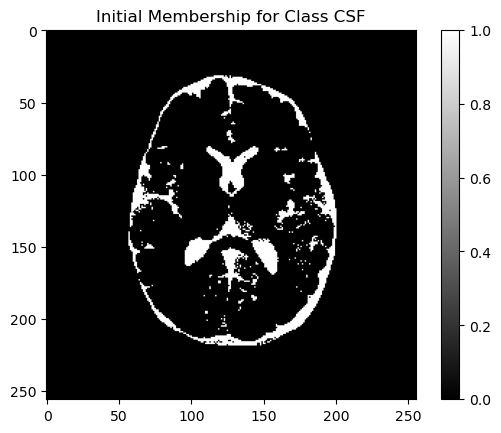

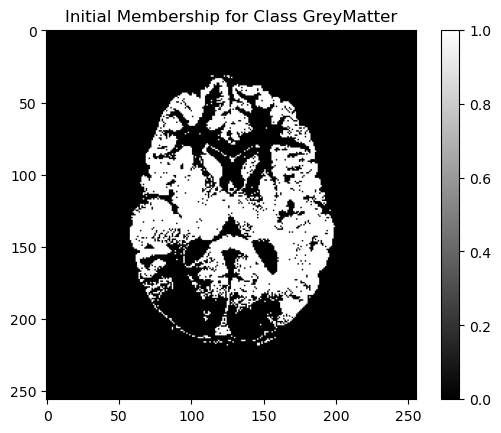

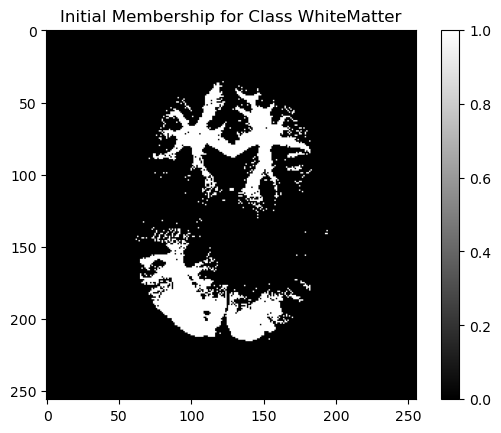

In [20]:
# 1. PREPARE MEMBERSHIP ARRAY
# -----------------------------------------------------------------
H, W = imageData.shape
K = 3  # number of classes (WM, GM, CSF)
membership_init = np.zeros((H, W, K), dtype=np.float32)

# 2. CRISP MEMBERSHIP ASSIGNMENT
# -----------------------------------------------------------------
for i in range(H):
    for j in range(W):
        if imageMask[i, j] == 1:  # inside the brain
            pixel_val = imageData[i, j]
            
            # Find the class whose mean is closest to this pixel
            # distance can be absolute difference or squared difference
            distances = [abs(pixel_val - m) for m in initial_means]
            k_star = np.argmin(distances)  
            
            # Hard assignment
            membership_init[i, j, k_star] = 1.0
        
        else:
            # Outside brain => membership is 0 for all classes
            membership_init[i, j, :] = 0.0

# 3. SAVE MEMBERSHIP MAPS
# -----------------------------------------------------------------
os.makedirs("membership_init", exist_ok=True)

out_path = os.path.join("membership_init", f"membership.npy")
np.save(out_path, membership_init)
print(f"Saved {out_path}")

# 4. OPTIONAL: VISUALIZE EACH MEMBERSHIP MAP
#    They will appear as binary images if you used strictly hard membership.
#    If you do "slight softening," you'll see grayscale values (mostly near 0.9 or 0).
# -----------------------------------------------------------------
classes = ["CSF", "GreyMatter", "WhiteMatter"]
for k in range(K):
    plt.figure()
    plt.imshow(membership_init[:, :, k], cmap='gray')
    plt.colorbar()
    plt.title(f"Initial Membership for Class {classes[k]}")
    plt.savefig(f"images/menbership_init_{classes[k]}.png", dpi=150)
    plt.show()